In [1]:
import autograd.numpy as np

from bloch.utils import get_arg_index
from bloch.mrf_spoiled_crlb import crb_mrf_objective

from bloch.utils import jacobian_pkl as jacobian

import matplotlib.pyplot as plt
import time as time

%load_ext autoreload
%autoreload 2

%matplotlib notebook

/home/pkllee/anaconda2/envs/tf3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
def crb_mrf_objective_wrapper(np_in, *args):
    M0, TEs, inversion_delay, T1, T2, _, mask_tuple = args
    
    if (mask_tuple is None):
        x_in = np_in
    else:
        x_in = np.copy(mask_tuple[0])
        x_in[mask_tuple[1]] = np_in
    
    return crb_mrf_objective(x_in, M0, TEs, inversion_delay, T1, T2)

def crb_mrf_grad_efficient(np_in, *args):
    M0, TEs, inversion_delay, T1, T2, opt_meta_data, mask_tuple = args
    
    f_x0 = crb_mrf_objective(np_in, M0, TEs, inversion_delay, T1, T2)   

    dcrb_dx_in = jacobian(crb_mrf_objective, get_arg_index(crb_mrf_objective, 'np_in'))
    
    df_dxi = dcrb_dx_in(np_in, M0, TEs, inversion_delay, T1, T2)
    
    return df_dxi


def crb_mrf_grad_numerical(np_in, *args):
    M0, TEs, inversion_delay, T1, T2, opt_meta_data, mask_tuple = args
    
    f_x0 = crb_mrf_objective(np_in, M0, TEs, inversion_delay, T1, T2)
    
    epsilon = 1e-3
    
    df_dxi = np.zeros(np_in.shape)
    
    for ii in range(0, np_in.size):
        x0_plus_dx_ii = np.copy(np_in)
        x0_plus_dx_ii[ii] = x0_plus_dx_ii[ii] + epsilon
        
        f_x0_plus_dx_ii = crb_mrf_objective(x0_plus_dx_ii, M0, TEs, inversion_delay, T1, T2)
        df_dxi[ii] = (f_x0_plus_dx_ii - f_x0) / epsilon        
    
    return df_dxi
    
    


In [ ]:
from bloch.mrf_sequence import get_flip_angles_scheme_2

times_grad_efficient = []
times_grad_numerical = []
times_objective = []
Ns = np.concatenate((np.linspace(10, 90, num=9),np.linspace(100, 1000, num=10))).astype(np.int64)
#Ns = np.linspace(10, 90, num=9).astype(np.int64)

for N in Ns:
    M0 = 1.
    TEs = np.ones((N)) * 5.8 # ms
    T1, T2 = (1330., 80.) # grey matter at 3T
    mrf_inversion_delay = 20 # ms

    FAs_init = get_flip_angles_scheme_2(N, target_std=0)

    T_sinusoid = 200
    TRs_init = np.sin(np.arange(0, N) * 2 * np.pi / T_sinusoid) * 2 + 13.5 # sinusoidal with period T

    array_init = np.concatenate((FAs_init, TRs_init), axis=0)
    args_tmp = (M0, TEs, mrf_inversion_delay, T1, T2, None, None)

    start = time.time()
    crb_mrf_objective_wrapper(array_init, *args_tmp)
    elapsed_time_objective = time.time() - start
    times_objective.append(elapsed_time_objective)
    
    start = time.time()
    crb_mrf_grad_efficient(array_init, *args_tmp)
    elapsed_time_efficient = time.time() - start
    times_grad_efficient.append(elapsed_time_efficient)
    
    start = time.time()
    crb_mrf_grad_numerical(array_init, *args_tmp)
    elapsed_time_numerical = time.time() - start
    times_grad_numerical.append(elapsed_time_numerical)
    
times_efficient = np.array(times_objective) + np.array(times_grad_efficient)
times_numerical = np.array(times_objective) + np.array(times_grad_numerical)


/home/pkllee/anaconda2/envs/tf3/lib/python3.6/site-packages/autograd/numpy/numpy_vjps.py:444: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return lambda g: g[idxs]


<IPython.core.display.Javascript object>


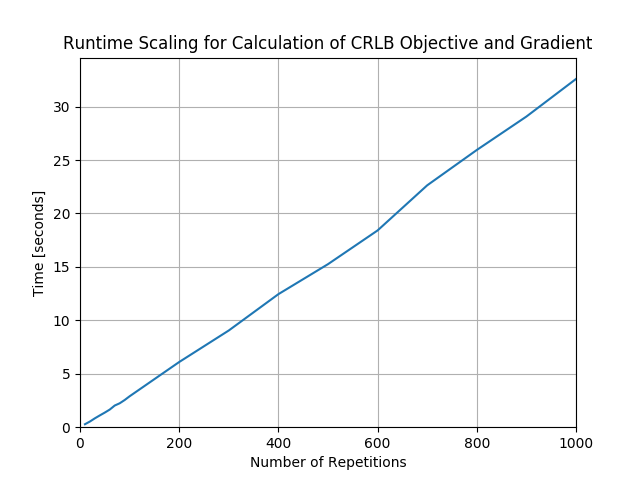

In [10]:
plt.figure()
plt.plot(Ns, times_efficient)
#plt.plot(Ns, times_objective)
plt.grid(True)
plt.xlabel('Number of Repetitions')
plt.ylabel('Time [seconds]')
plt.title('Runtime Scaling for Calculation of CRLB Objective and Gradient')
plt.xlim([0, np.amax(Ns)])
plt.ylim([0, np.amax(times_efficient) + 2])
plt.show()

<IPython.core.display.Javascript object>


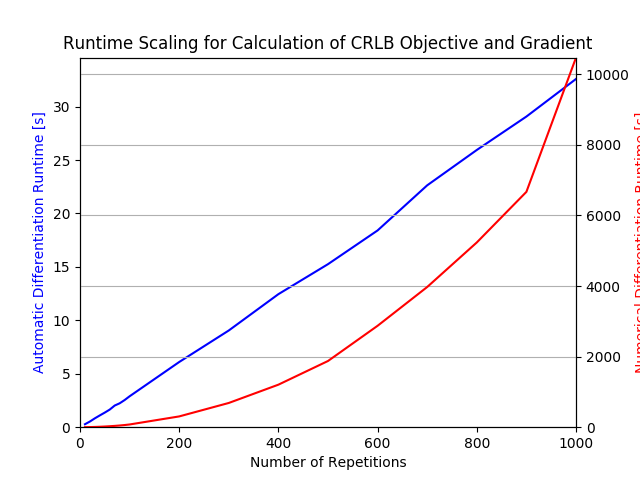

In [11]:
fig, ax1 = plt.subplots()
ax1.plot(Ns, times_efficient, 'b-')


plt.xlabel('Number of Repetitions')
plt.ylabel('Automatic Differentiation Runtime [s]', color='b')
plt.ylim([0, np.amax(times_efficient) + 2])

ax2 = ax1.twinx()
ax2.plot(Ns, times_numerical, 'r-')

plt.grid(True)
plt.ylabel('Numerical Differentiation Runtime [s]', color='r')
plt.title('Runtime Scaling for Calculation of CRLB Objective and Gradient')
plt.xlim([0, np.amax(Ns)])
plt.ylim([0, np.amax(times_numerical) + 2])

plt.show()

lsq fit eff:  
1.044 x - 1.627
lsq fit num:  
2.011 x - 2.124


<IPython.core.display.Javascript object>


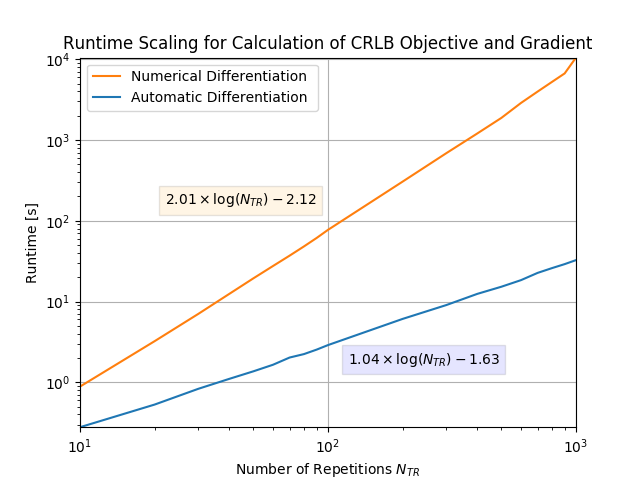

/home/pkllee/anaconda2/envs/tf3/lib/python3.6/site-packages/matplotlib/axes/_base.py:3157: UserWarning: Attempted to set non-positive xlimits for log-scale axis; invalid limits will be ignored.
  'Attempted to set non-positive xlimits for log-scale axis; '
/home/pkllee/anaconda2/envs/tf3/lib/python3.6/site-packages/matplotlib/axes/_base.py:3477: UserWarning: Attempted to set non-positive ylimits for log-scale axis; invalid limits will be ignored.
  'Attempted to set non-positive ylimits for log-scale axis; '


In [78]:
coeffs_eff = np.poly1d(np.polyfit(np.log10(Ns), np.log10(times_efficient), 1))
coeffs_num = np.poly1d(np.polyfit(np.log10(Ns), np.log10(times_numerical), 1))
print("lsq fit eff: " + str(coeffs_eff))
print("lsq fit num: " + str(coeffs_num))

addiff_legend = 'Automatic Differentiation '
numdiff_legend = 'Numerical Differentiation '
addiff_label = r'$1.04 \times \log{(N_{TR})} - 1.63$'
numdiff_label = r'$2.01 \times \log{(N_{TR})} - 2.12$'

fig, ax = plt.subplots()

plt.loglog(Ns, times_numerical, 'C1', Ns, times_efficient, 'C0')

plt.xlabel(r'Number of Repetitions $N_{TR}$')

plt.grid(True)
plt.ylabel('Runtime [s]')
plt.title('Runtime Scaling for Calculation of CRLB Objective and Gradient')
plt.xlim([0, np.amax(Ns)])
plt.ylim([0, np.amax(times_numerical)])
plt.legend([numdiff_legend, addiff_legend])


plt.text(90, 180, numdiff_label, verticalalignment='center', horizontalalignment='right', bbox=dict(facecolor='orange', alpha=0.1))
plt.text(120, 1.9, addiff_label, verticalalignment='center', horizontalalignment='left', bbox=dict(facecolor='blue', alpha=0.1))
plt.show()

In [17]:
1/0
np.savetxt('tmp/times_grad_efficient.txt', times_efficient)
np.savetxt('tmp/times_grad_numerical.txt', times_numerical)
np.savetxt('tmp/times_objective.txt', times_objective)

ZeroDivisionError: division by zero

In [ ]:
tmp = np.loadtxt('tmp/times_grad_efficient.txt')
print(tmp)